In [1]:
import librosa
audio_path = 'audio-path'
samples = []
sr = 48000
x , sr = librosa.load("s2.wav", sr = 48000)
samples.append(librosa.load("s2.wav", sr = 48000)[0])
samples.append(librosa.load("s1.wav", sr = 48000)[0])
print(type(x), type(sr))

<class 'numpy.ndarray'> <class 'int'>


In [2]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
print(Xdb[2] == Xdb[1])

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

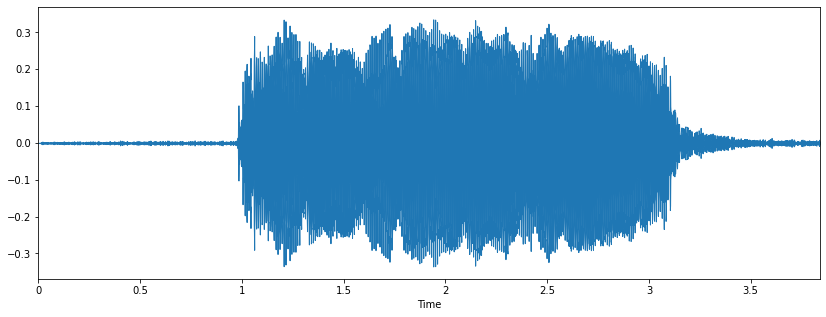

In [3]:
#display waveform
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

TypeError: A_weighting() got an unexpected keyword argument 'sr'

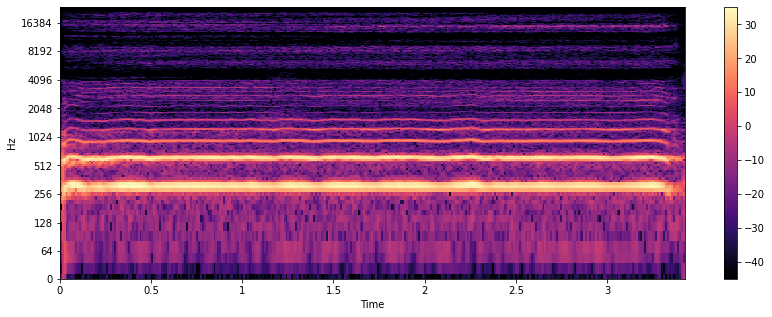

In [6]:
#display Spectrogram
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz') 
#If to pring log of frequencies  
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

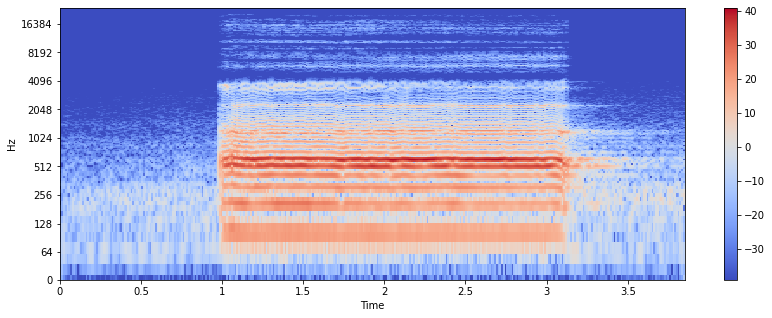

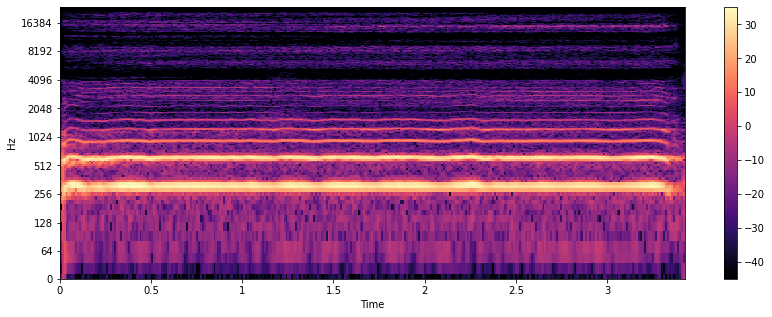

In [5]:
for x in samples:
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(14, 5))
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz') 
    #If to pring log of frequencies  
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

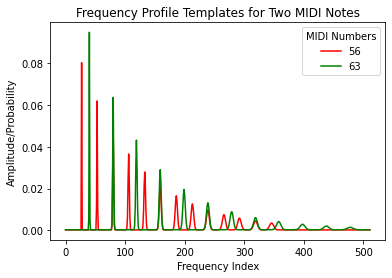

array([0.00020993, 0.00020993, 0.00020993, 0.00020993, 0.00020993,
       0.00020993, 0.00020993, 0.00020993, 0.00020993, 0.00020993,
       0.00020993, 0.00020993, 0.00020993, 0.00020993, 0.00020993,
       0.00020993, 0.00020993, 0.00020993, 0.00020993, 0.00020993,
       0.00020993, 0.00020993, 0.00020993, 0.00020993, 0.00020993,
       0.00020993, 0.00034745, 0.0803367 , 0.00034473, 0.00020993,
       0.00020993, 0.00020993, 0.00020993, 0.00020993, 0.00020993,
       0.00020993, 0.00020993, 0.00020993, 0.00020993, 0.00020993,
       0.00020993, 0.00020993, 0.00020993, 0.00020993, 0.00020993,
       0.00020993, 0.00020993, 0.00020993, 0.00020993, 0.00020993,
       0.00020994, 0.00027612, 0.01144379, 0.0619918 , 0.01122134,
       0.00027353, 0.00020994, 0.00020993, 0.00020993, 0.00020993,
       0.00020993, 0.00020993, 0.00020993, 0.00020993, 0.00020993,
       0.00020993, 0.00020993, 0.00020993, 0.00020993, 0.00020993,
       0.00020993, 0.00020993, 0.00020993, 0.00020993, 0.00020

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Define states
LOW_MIDI = 47
HIGH_MIDI = 74
STATES_PER_NOTE = 5
STATE_VALUES = ((HIGH_MIDI - LOW_MIDI) + 2) * STATES_PER_NOTE # REPLACE IT WITH THE TOTAL NUMBER OF POSSIBLE STATES (INCLUDING "SILENCE")

# Define initial distribution
init_dist = np.zeros(STATE_VALUES)
for i in range(STATE_VALUES):
    if i % STATES_PER_NOTE  == 0: # equal chance of being in the first state of any note
        init_dist[i] = 1/STATE_VALUES

# Define transition matrix
A = np.zeros((STATE_VALUES, STATE_VALUES))
for i in range(A.shape[0]): # for each state
    A[i, i] = 1 # every state has a self loop
    if (i+1)%STATES_PER_NOTE  != 0: # if this state is not the fifth state of a note
        A[i, i+1] = 1 # this state has an arrow to the next state (which is within the same note)
    else: # if this state is the fifth state of a note
        for j in range(STATE_VALUES // STATES_PER_NOTE):
            A[i, j*STATES_PER_NOTE ] = 1

# Normalize every row so each row sums to 1
for i in range(A.shape[0]):
    A[i, ] = A[i, ] / sum(A[i, ])


import math

def peak_fun(x):
    """
    Constructs and returns a harmonic peak
    """
    return math.exp(-0.5*x*x)


def midi2freq(midi):
    """
    Returns the frequency (in Hz) of the given midi number
    """
    return 440*np.power(2, (midi-69)/12)


def template(midi, N, sr):
    """
    Returns a frequency profile template for the given midi note.
        midi: midi number
        N: frame size (must be an even number)
        sr: sample rate
    """
    if N % 2 != 0:
        print("Frame size is not even!")
        return None
    f0 = midi2freq(midi) # fundamental frequency
    H = 13 # maximumn number of harmonics to include
    bins = math.floor(N/2) # half of the DFT result
    template = np.zeros(bins) 
    
    for h in range(1, H+1): # h = 1, 2, 3, ..., H
        bin = round(f0*h*N/sr) # bin index of this harmonic
        if bin >= bins: # exceeds Nyquist frequency
            break
        sigma = bin * 0.01 + 0.01 # controls the width of the peak
        for k in range(bins):
            x = (k-bin)/sigma
            template[k] += math.exp(-k*0.01) * peak_fun(x) # descreasing amplitudes for higher frequencies
    
    for k in range(bins):
        template[k] += 0.002
    # Normalize all bins:
    total = sum(template)
    if (total > 0):
        template = template / total
    else:
        print("The template has 0 everywhere!")
    return template


def create_midi_templates(N, sr):
    """
    Returns a dictionary where the key is a midi number (or 0) and
    the value is the template of this midi note.
    (silence is represented by 0)
    """
    templates = {}
    for midi in range(LOW_MIDI, HIGH_MIDI + 1):
        templates[midi] = template(midi, N, sr)
    # Template for "silence":
    templates[0] = np.repeat(1/math.floor(N/2), math.floor(N/2)) # flat template
    return templates

## YOUR CODE HERE...
created_templates = create_midi_templates(1024, 8000)
plt.plot(created_templates[56], color="red")
plt.plot(created_templates[63], color="green")
plt.legend(('56','63'), loc = 'upper right', title = 'MIDI Numbers')
plt.xlabel("Frequency Index")
plt.ylabel("Amplitude/Probability")
plt.title("Frequency Profile Templates for Two MIDI Notes")
plt.show()
created_templates[56]